### Capítulo 2

Ahora que ya logramos escribir nuestro primer programa en `CUDA C`, pasaremos a un conocimiento un poco más profundo sobre el funcionamiento del `hardware` al programar en paralelo.

### SM y Warps

Una tarjeta gráfica está compuesta de un gran número de núcleos idénticos al de un `CPU`. De alguna manera es como si la tarjeta gráfica fuera un gran número de `CPU`s. En este curso no ahondaremos en la estructura de los núcleos, sino que repasaremos aquellos componentes más importantes como el `SIMD`o *Single Instruction Multiple Data*, el cual permite que los `threads` realicen una única operación. Otro componente más relevante para nuestro propósito es el *SM*.

**Nota:** Para más información sobre la estructura de un `CPU`, leer sobre el modelo de von Neumann. En las referencias se encuentran algunos lugares donde leer sobre esto.

#### SM

Quien se ocupa de ordenar y ejecutar los `blocks` son los `SM` o *Streaming Multiprocessors*. Ellos dan y mantienen los índices a los `threads` y a los `blocks`. Estos tienen la caracteristica de sólo permitir la entrada de 8 bloques y de 1536 `threads`, por lo que nos restringe la dimensión de los bloques con los que trabajaremos. 

Toda esta información se encuentra en los documentos de CUDA localmente. Para esto, en la carpeta de `Samples/` que fue instalada con CUDA encontrarás la carpeta `1_Utilities`. Ábrela y encontrarás un gran número de herramientas que te serán muy útiles para conocer las propiedades locales. Por el momento únicamente nos importa `deviceQuery`.

In [ ]:
!cd ~/NVIDIA_/1_Utilities/deviceQuery && deviceQuery

Aquí obtendremos las especfiicaciones de la tarjeta gráfica local. Entre estas propiedades está el número máximo de threads totales que pueden ser lanzados a la hora de compilar. También encontramos el número máximo de threads que pueden ser lanzados en un mismo bloque. Esto nos puede poner en aprietos a la hora de escribir nuestro código. 

Veamos por qué.

Ya hemos visto que el máximo número de bloques utilizables es 8. Ahora bien, nos interesa saber qué dimensión de bloques maximiza la la capacidad del `SM`. Esto podrá ser observado en las gráficas siguientes

In [19]:
from matplotlib import pyplot as plt
import numpy as np

def capacidad(num_max_threads_total, num_max_threads_bloque):
    
    N = int(np.sqrt(num_max_threads_bloque))
    Capacidad = np.zeros(N)
    Bloques = np.zeros(N)
    
    for i in xrange(N):
        
        n = i+1
        num_threads_bloque = n*n
        threads_usados = 8*num_threads_bloque
        
        bloques_utilizados = num_max_threads_total/num_threads_bloque
        
        if bloques_utilizados > 8:
            Capacidad[i] = (8.*num_threads_bloque)/num_max_threads_total
            Bloques[i] = 8
            
        elif bloques_utilizados == 8: 
            Capacidad[i] = 1.
            Bloques[i] = 8
        
        elif bloques_utilizados < 8:
            Capacidad[i] = (float(bloques_utilizados)*num_threads_bloque)/num_max_threads_total
            Bloques[i] = bloques_utilizados
        
    plt.figure(figsize=(10,10))
    plt.plot([i+1 for i in xrange(N)], Capacidad)
    plt.title('Capacidad total con respecto a la dimension n de los bloques (nxn)')
    plt.xlim(1,N+1)
    plt.xlabel("n")
    plt.ylim(0.,1.1)
    plt.ylabel("Capacidad")
    plt.grid()

    plt.figure(figsize=(10,10))
    plt.plot([i+1 for i in xrange(N)], Bloques)
    plt.title("Bloques utilizados con respecto a la dimension n de los bloques (nxn)")
    plt.xlim(1,N+1)
    plt.xlabel("n")
    plt.ylim(1, 10)
    plt.ylabel("Bloques")
    plt.grid()

In [20]:
%matplotlib inline

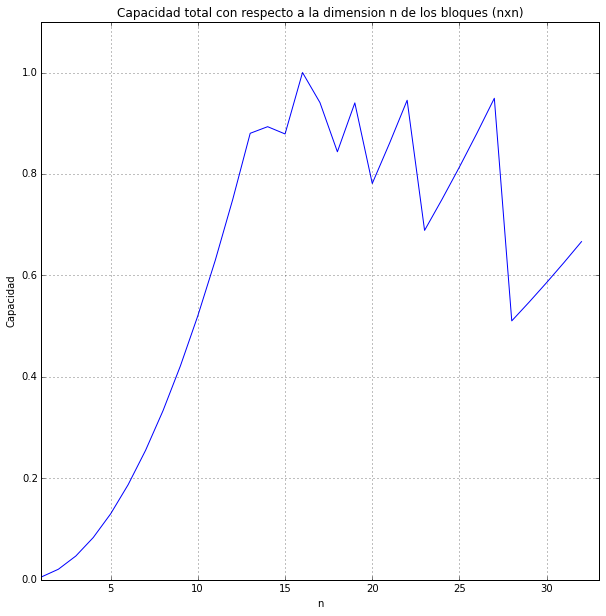

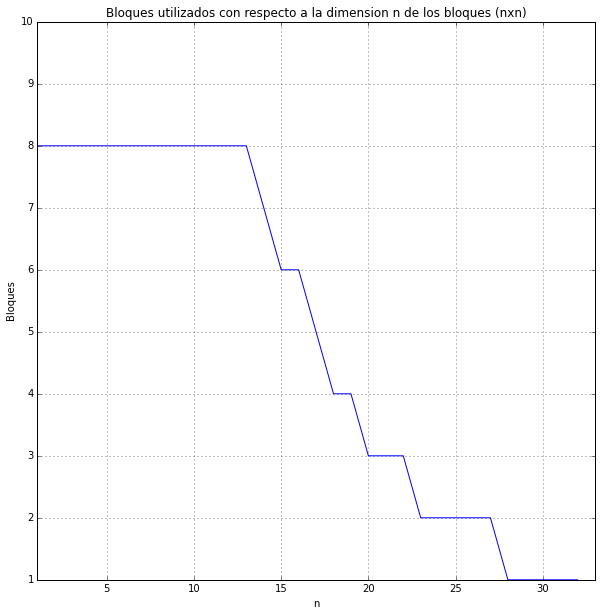

In [21]:
# A partir de la información obtenida del deviceQuery llena las variables siguientes

num_max_threads_total = 1536
num_max_threads_bloque = 1024

capacidad(num_max_threads_total, num_max_threads_bloque)

Entonces, ¿qué dimensión n nos conviene tomar? 

Según los resultados obtenidos anteriormente bloques $16\times16$ nos darán la mejor eficiencie en nuestro código. Revisemos cómo se calcula esto. 

- Supongamos que trabajaremos con bloques de 8x8. Esto quiere decir que cada bloque tendrá 64 `threads`. Para llenar un `SM` entonces necesitaremos 1536/64 = 24 bloques, sin embargo sólo podremos utilizar 8 debido a las restricciones que nos pone la `SM`, haciendo que descartemos 16 bloques y trabajemos únicamente con 8 bloques, es decir 512 `threads`. Esta cantidad representa únicamente 1/3 de la capacidad de los `SM`.

- Supongamos ahora que tenemos bloques de 16x16. Esto implica que cada uno de estos tendrá 256 `threads`. Al dividir 1536 entre 256 obtenemos un resultado de 6, por lo que necesitaremos 6 bloques (debajo del límite permitido) para llenar el espacio de un `SM`, utilizando así toda su capacidad.

- Finalmente tenemos el caso de 32x32, lo cual significa que cada bloque tendrá 1024 `threads`. Esto hace que sólo podamos utilizar un bloque en el `SM`, haciendo que 512 espacios para `threads` queden desocupados, haciendo finalmente que utilicemos 2/3 de la capacidad total del `SM`.

En conclusión podemos ver como la elección de la dimensión de los bloques afecta en la capacidad y eficacia de nuestro programa. Por lo que siempre hay que detenerse a pensar sobre la dimensión más apta según el problema que tengamos.

#### Warps

Los *Warps* son otra división "natural" de los `threads` dentro de los bloques. Cada `Warp` está conformado por 32 `threads` y al igual que estos últimos y los `blocks`, los `warps` también están indexados. Por lo que el `warp` 0 empieza en el mismo lugar que el `thread` 0 y termina en el `thread` 31. 
¿Qué ocurre en el caso de bloques tridimensionales? Se hace un mapeo a una dimensión en analogía a la fórmula utilizada en los códigos anteriormente escritos ` int i = blockIdx.x * blockDim.x + threadIdx.x `.

Cuando el código es compilado y ejecutado, el `kernel` busca `warps` que estén listos en un primer tiempo. Este no puede ejecutar a todos los `warps` al mismo tiempo, sino que ejecuta a una pequeña cantidad. A estos último se les llama `ready warps` o simplemente `warps listos`. Estos son ejecutados en un primer tiempo debido a que todos sus operandos ya están listos y pueden proceder a la ejecución. La no ejecución de los demás `warps` se debe a que sus operandos aún no están listos. Estos estarán listos cuando la memoria global les dé la información suficiente para ejecutarse, o cuando una `ULA` le de la información sobre una operación que esté realizando.

### Divergencia de Control

Los distintos `threads` dentro de un `warp` pueden estar o no estar sincronizados. Esto significa que pueden o no estar haciendo la misma operación. Esto afecta directamente en el funcionamiento del programa en cuestión. Si por ejemplo la mitad de los `threads` dentro de un `warp` está realizando una operación A mientras que la otra mitad una operación B, la eficacia del código se ve afectada a comparación del caso en el que todos los `threads` de un `warp` realizan una sola operación. 
A esta falla en el funcionamiento se le llama *Divergencia de Control*.

**Ejemplo:** 
+ Imaginemos un código en el cual encontremos un condicional de la forma: ` if (threadIdx.x > 2) {} `. Esto significa que en el primer `warp` de nuestro bloque, los primeros 3 `threads` harán una cierta operación, mientras que los otros 29 harán otra. En este caso habrá una divergencia de control.

+ Esta divergencia puede evitarse con condicionales de esta forma: ` if (blockIdx.x > 2) {} `. En este caso todos los `warps` en el bloque 0, 1 y 2 harán una operación, mientras que los demás bloques harán otra (nota como el número de `threads` que un bloque puede contener es multiplo de 32 según el ejemplo anterior).

Regresemos ahora al caso de nuestra multiplicación de vectores. Supongamos que `n = 1000`. Recordemos parte del código:

```C
__global__ void multiplicacion_vectores( float * d_A, float * d_B, float * d_C, int n) {

    int i = blockIdx.x * blockDim.x + threadIdx.x ;
    if (i<n) { 
                d_C[i] = d_A[i] * d_B[i] ; 
             }
    } 
```

Para cubrir las 1000 entradas de los vectores, utilizaremos 32 `warps` que nos darán 1024 `threads`. Como puede intuirse ya, tendremos una divergencia de control en (y sólo en) el último `warp`. Esto debido a que los primeros 8 `threads` harán la operación en el `kernel`, mientras que el resto no. Por ahora no podemos hacer nada al respecto para eliminar esta divergencia.

Es importante notar que esta divergencia no es lo suficientemente grande para que esta pueda afectar gravemente el funcionamiento de nuestro código.

### Tipos de Memoria

Existen distintos tipos de memoria en un `GPU`. Sin embargo, antes de nombrarlos empezaremos con una pequeña analogía para entender mejor qué ocurre en el `hardware`. 

Supongamos un salón de clase en el que se encuentran 24 niños distribuidos en 4 mesas con 6 sillas cada una. El profesor les deja como tarea el solucionar un problema. Sin embargo la resolución del problema tiene que ser hecha en 4 partes distintas. Cada una de estas partes es asignada a sólo una mesa, y los niños que conforman esta han de trabajar en equipo. 
De esta manera, un niño puede leer y escribir en su cuaderno, en una pequeña pizarra asignada a cada mesa y en el gran pizarrón que se encuentra en el salón. 
Sin embargo hay dos restricciones: los niños de una mesa no pueden ni leer ni escribir en la pizarra de otra mesa y ningún niño puede leer ni escribir en el cuaderno de otro niño.

La memoria del `GPU` funciona de la misma manera. Si los niños fueran `threads`, la mesa un `block` y el salón una `grid`, entonces:

+ El cuaderno sería el  `register`  o *registro*, en el cual sólo un `thread` puede leer y escribir sus variables locales.
+ La pizarra asignada a cada mesa sería la  `shared memory`  o *memoria compartida*, a la que pueden acceder cada `thread` dentro de un bloque. Sin embargo los `threads` de otro bloque no.
+ El pizarrón del salón sería la  `global memory`  o *memoria global*, en la que pueden acceder *todos* los `threads`.
+ Además, en el `GPU` existe también la  `constant memory`  o *memoria constante*, que es muy similar a la memoria global.
<img src=Imagenes/Memorias.png align=center>
<h4 align=center> Esquema que muestra los distintos tipos de memoria en una tarjeta gráfica y las interacciones entre ellas. "R." es por *registro*, mientras que "Th." es por `thread`.</h4>

### Variables ` __device__ `

De esta manera llegamos a los distintos tipos de variables ` __device__ `. Encontramos 4, las cuales son:

+ Variable Local, la cual es declarada como ` int LocalVar ;`. Esta vive en el `registro` y puede ser escrita y leída únicamente por un `thread`. Su tiempo de vida es igual al tiempo de vida del `thread` al cual está atada, lo que significa que es declarada cuando el `thread` es ejecutado y eliminada cuando este muere.
+ Variable Compartida, la cual es declarada como ` __device__ __shared__ int SharedVar ; `. Esta vive en la `memoria compartida`. Un mismo bloque puede leerla y modificarla, mientras que su tiempo de vida es igual al del bloque.
+ Variable Global, la cual es declarada como ` __device__ int GlobalVar ; `. Esta vive en la `memoria global` y puede ser leída y escrita por toda la `grid`. Su tiempo de vida es igual al de la ejecución del programa.
+ Constante, la cual es declarada como ` __device__ __constant__ int ConstantVar ; `. Tiene las mismas caracteristicas que la variable global, con la diferencia que vive en la `memoria constante`.

**Nota:** en el caso de las variables compartidas y constantes, el ` __device__ ` en la declaración puede ser omitido.

Una pregunta valida en este punto sería ¿por qué vemos hasta este momento este tipo de variables?, ¿que no ya habíamos declarado variables similares en la multiplicación de vectores?

En realidad la respuesta yace en el hecho de que no se quería confundir aún más al lector desde un principio. También, estos tipos de memoria responden a una demanda de optimización, más no de estructura tal cual. El poder escribir un primer código sencillo (o uno más complicado) prescinde del utilizar otros tipos de memoria.

Sin embargo, si dicho individuo desea un conocimiento más profundo y las herramientas para volver más eficiente su código, entonces es importante el saber manejar distintas memorias. Muy pronto nos avocaremos a cuestiones de eficiencia del código, por lo que el conocimiento de la memoria **compartida** tiene un gran valor para nosotros.

**Ejemplo:** Adelantándonos un poco a  lo que se verá más adelante, presentamos parte de un `kernel` para multiplicación de matrices en el que utilizaremos la `memoria compartida`. Sin prestarle atención a los detalles, este ejemplo tiene la única intención de mostrar como se declaran `variables compartidas`.

```C

__global__ void MulMatrices_Kernel( int m, int n, int k, float * A, float * B, float * C ) { 
    
      __shared__ float tesela_A[ANCHO_TESELA][ANCHO_TESELA] ; 
      __shared__ float tesela_B[ANCHO_TESELA][ANCHO_TESELA] ; 
    
    .
    .
    .

    } 
```

**¿Dónde declarar las variables?**

El procedimiento es muy sencillo. Uno debe preguntarse: **¿El `host` podrá acceder a estas?**

+ Sí: entonces la variable es global o constante, por lo que debe de ser declarada afuera de cualquier función.
+ No: entonces la variable es local o un registro, por lo que debe de ser declarada dentro del `kernel`.

**¿Cuales son las ventajas de tener tantos tipos de memoria?** 

La respuesta será descubierta conforme al avance de nuestros conocimientos en `CUDA C`, sin embargo como un pequeño adelanto podemos mencionar que la velocidad en que un `thread` accede a la información de la memoria compartida es de 1 a 2 órdenes de magnitud mayor que la velocidad en la que accede a la memoria global. Por lo que a la hora de escribir un código de un nivel avanzado, estos factores cuentan en la eficiencia y el funcionamiento de nuestro programa.

### Multiplicación de Matrices (ejemplo básico)

Cualquiera que haya ya hecho un código de multiplicación de matrices recordará que la idea es muy básica. Lo mismo será en el caso de CUDA C.

Sin embargo vale la pena poner especial atención a la manera de indexar los `threads` y como se forman las columnas y renglones de la matriz.

También es importante notar que en este código ya pasaremos a dos dimensiones, `x` y `y`. No hay de qué preocuparse.

En primero lugar, y únicamente para hacernos la vida un poco más sencilla, escribiremos:
```C

tx = threadIdx.x ; ty = threadIdx.y ;
bx = blockIdx.x ; by = blockIdx.y ;
```

Ahora los indices `Fila` y `Col`. Básicamente estos son iguales al índice `idx` con el que jugamos en el `kernel` de multiplicación de vectores, con la diferencia que ahora tendremos dos por las dos dimensiones del problema.

De esta manera: 

```C

Fila = by * blockDim.y + ty ;
Col = bx * blockDim.x + tx ;
```


Ahora hablemos del algoritmo. En este ejemplo las matrices no estarán hechas como un arreglo de dos dimensiones, sino que se mapeará hacia un arreglo de una dimensión (revisar la plantilla escrita para este ejercicio un poco más abajo). Esto quiere decir que tendremos que pasar de la indexación `[Fila][Columna]` a una en una dimensión.

El razonamiento es exactamente el mismo con el que se escribió el índice `idx`, `Fila` y `Col`. Eligiremos a una fila y la limitaremos por el numero de columnas que hay. A eso le sumaremos el índice dinámica que se mueve por las columnas en esa fila.
Nuestra nueva indexación queda como `[Fila * numCol + i]`, donde numCol es el número de columnas que la matriz tiene.

El algoritmo queda entonces así:

```C
if (Fila < numFilasC && Col < numColC) {
    float Cvalue = 0.0 ;
    for (int i = 0 ; i < numColA ; i ++) {
        Cvalue += A[Fila * numColA + i] * B[Col + i*numColB] ;
        __syncthreads() ;
        }
    C[Fila * numColC + Col] = Cvalue ;
    __syncthreads() ;
    }
```

Nótese los cambios que hay en el índice de la matriz B. También es importante notar la misteriosa función `__syncthreads() ` que incluímos al final de los cálculos. Esto será explicado a continuación.

Antes de continuar es **importante** hacer notar que los cambios que hace un `thread` en las variables compartidas o globales no son vistos *inmediatamente* por los demás, por lo que es importante asegurarse de que un `kernel` haya terminado de realizar los cálculos desados antes de iniciar otro. Esto para que los cambios realizados por el primero puedan ser vistos completamente por el siguiente. La función `__syncthreads()` será la manera en la cual nos aseguraremos que esto pase.

 Cada `thread` funciona de manera independiente, por lo que no podemos asegurar que todos tomen el mismo tiempo para hacer las operaciones que deben. Esto puede provocar en algunos códigos que funciones dentro del kernel empiecen cuando la información que van a procesar no está completa. 
 
 Siguiendo el ejemplo de los niños dentro del salón. Supongamos que llega la hora de la comida, y cada uno de los niños debe tomar el camión escolar para regresar a su casa. 
 Imaginemos por un momento que el camión deje a uno de los niños en la escuela. Esto le provocaría problemas tanto al chofer del camión como a la escuela por la queja de los padres. Para evitar esto, el chofer debe de asegurarse que **todos** los niños estén dentro del camión antes de que pueda arrancar. 
 
 Regresando al caso de la computación en paralelo, los niños siguen siendo los `threads` mientras que el chofer que se asegura que todos los niños estén en el camión es la función ` __syncthreads() `. El no poner esta función equivaldría a que el chofer pudiera olvidar a uno de los niños. 
 
 De esta manera, al colocar la función ` __syncthreads() ` dentro del kernel nos aseguramos que todos los threads que están calculando un coeficiente $C_{y,x}$ terminen de calcularlo antes de pasar al cálculo de otro coeficiente $C_{y',x'}$.

El kernel no tiene, a parte de las funciones ` __syncthreads() `, gran diferencia con respecto a un código escrito en cualquier lenguaje de programación serial. Los condicionales `if` son para asegurarnos que no se sobreescriba información en el cálculo de $C$. 

<img src=Imagenes/Syncthreads.png align=center>
<h4 align=center >Ilustración de como funciona ` __syncthreads()`. Esta está representada aquí como la envoltura que no deja seguir a los `threads` a la siguiente etapa hasta que el último (`thread N-2`) termine sus operaciones<h4>


Sin más, pasemos a escribir el código completo de una multiplicación de matrices

In [ ]:
%%writefile Programas/Mul_matrices.cu

__global__ void multiplicacion_matrices()
{
    // llenar el kernel
    
    // En primer lugar declara todos los indices que utilizaras
    
    // Luego escribe el codigo con el cual se realizaran los calculos para
    // obtener la matriz C. No olvides colocar la funcion __syncthreads().
    
}

int main( int argc, char * argv[])
{
    
    int numColA 1000 ;
    int numColB 1000 ;
    int numColC 1000 ;
    
    int numFilaA 1000 ;
    int numFilaB 1000 ;
    int numFilaC 1000 ;
    
    float A[numFilaA*numColA] ;
    float B[numFilaB*numColB] ;
    float C[numFilaC*numColC] ;
    
    for (i = 0 ; i < numFilaA*numColA ; i ++)
    {
        A[i] = i ;
    }

    for (i = 0 ; i < numFilaB*numColB ; i ++)
    {
        B[i] = i + 1 ;
    }
    
    // Escribe abajo las lineas para la alocacion de memoria
    
    // Escribe abajo las lineas para la copia de memoria del CPU al GPU
    
    // Escribe las dimensiones de los bloques y mallas
    
    // Escribe las lineas para lanzar el kernel
    
    // Copia la memoria del GPU al CPU
      
    // Libera la memoria
      
    // Escribe un codigo para poder saber si tu resultado es correcto
    
    
    return 0 ;
}

In [ ]:
!nvcc -o /Programas/Mul_matrices Programas/Mul_matrices.cu

##  Referencias

+ Wiki de la [arquitectura de von Neumann](https://en.wikipedia.org/wiki/Von_Neumann_architecture)
+ Las figuras presentadas para visualizar la función `__syncthreads()` y los diferentes tipos de memoria, al igual que muchas ideas de este notebook están basadas en el curso **Heterogenous Parallel Programming** en [Coursera](https://www.coursera.org/course/hetero)